### Analyse generated sequences

The data in the first two plots was generated with this code:

In [ ]:
# def generative_replay(model, num=100, temperature=1):
#     examples = []
#     while len(examples) < num:
#         out = model.continue_input("FROM:", 
#                                    do_sample=True,
#                                    temperature=temperature)
#         # Leave out the last sequence as it stopped midway through
#         examples.extend(out.split('\n')[:-1])
#     shuffle(examples)
#     return examples


# word_freq_results = []
# train_size=50
# sample_size=100

# training_strs, testing_strs = prepare_data(default=True)

# list_to_write = training_strs[0][0:train_size]
# train_on_env(training_strs, 
#      testing_strs, 
#      list_to_write,
#      eps=10, 
#      lr=5e-05,
#      num_train=train_size, 
#      env=0, 
#      base_model='base_model_b8', 
#      oversample_num=4000)

# temps = [0.3, 0.9, 1.5, 2.1]
# for temp in temps:
#     for i in range(5):
    
#         generated_strs = generative_replay(GPT(base_model=f'spatial_model_0'), 
#                                               temperature=temp)
    
#         locs = get_unique_locations(generated_strs)
#         word_freq_results.append({'model': 1, 
#                                   'locs': locs, 
#                                   'temp': temp, 
#                                   'train_size': train_size, 
#                                   "sample_size": sample_size, 
#                                   "seqs": generated_strs, 
#                                   "training_strs": training_strs, 
#                                   "testing_strs": testing_strs})
#         with open('word_freq_results_imagined.pkl', 'wb') as file:
#             pickle.dump(word_freq_results, file)

#### Visualisations

In [86]:
import pickle
from testing_utils import *
import matplotlib.pyplot as plt
from scipy.stats import sem

input_file = 'word_freq_results_imagined_v2.pkl'

# Loading the data from the pickle file
with open(input_file, 'rb') as file:
    results_dict = pickle.load(file)

In [87]:
def analyze_sequences(results):
    # Extract necessary data
    current_env = results['model']  
    training_strs = results['training_strs']
    testing_strs = results['testing_strs']
    train_size = results['train_size']
    seqs = results['seqs']

    # Initialize results storage
    analysis_results = {'real': [], 'valid': [], 'neither': []}

    # Iterate through each sequence in seqs
    for seq in seqs:
        found_as_real = False
        found_as_valid = False

        # Check for real sequences in previous phases
        for i in range(current_env):
            if seq in training_strs[i][0:train_size]:
                analysis_results['real'].append(seq)
                found_as_real = True
                break  # Stop searching if found

        if not found_as_real:
            # Check for valid sequences if not found as real
            for i in range(current_env):
                if seq in training_strs[i][train_size:] or seq in testing_strs[i]:
                    analysis_results['valid'].append(seq)
                    found_as_valid = True
                    break  # Stop searching if found

        if not (found_as_real or found_as_valid):
            # If the sequence is neither real nor valid
            analysis_results['neither'].append(seq)

    return analysis_results

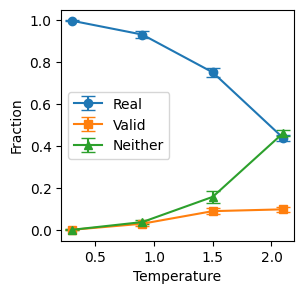

In [88]:
def analyze_sequences_by_temperature(results_dicts):
    temperature_results = {}

    for results in results_dicts:
        temp = results['temp']  # Assuming 'temp' is how temperature is recorded
        if temp == -1:  # Skip the analysis for temperature -1
            continue
        analysis_results = analyze_sequences(results)
        total_length = len(analysis_results['real'] + analysis_results['valid'] + analysis_results['neither'])

        # Initialize lists if this is the first time we're adding data for this temp
        if temp not in temperature_results:
            temperature_results[temp] = {'real': [], 'valid': [], 'neither': []}

        if total_length > 0:
            # Append the fraction to the list for each category
            temperature_results[temp]['real'].append(len(analysis_results['real']) / total_length)
            temperature_results[temp]['valid'].append(len(analysis_results['valid']) / total_length)
            temperature_results[temp]['neither'].append(len(analysis_results['neither']) / total_length)
        else:
            # Optionally handle the case where total_length is 0; decide how you want to treat this case
            pass  # For now, do nothing (or you could append 0 or None as placeholders)

    return temperature_results

def visualize_results(temperature_results):
    temps = sorted(temperature_results.keys())
    # Calculate means and SEMs
    reals_means = [np.mean(temperature_results[temp]['real']) for temp in temps]
    valids_means = [np.mean(temperature_results[temp]['valid']) for temp in temps]
    neithers_means = [np.mean(temperature_results[temp]['neither']) for temp in temps]
    
    reals_sems = [sem(temperature_results[temp]['real']) for temp in temps]
    valids_sems = [sem(temperature_results[temp]['valid']) for temp in temps]
    neithers_sems = [sem(temperature_results[temp]['neither']) for temp in temps]

    plt.figure(figsize=(3, 3)) 
    plt.errorbar(temps, reals_means, yerr=reals_sems, label='Real', marker='o', linestyle='-', capsize=5)
    plt.errorbar(temps, valids_means, yerr=valids_sems, label='Valid', marker='s', linestyle='-', capsize=5)
    plt.errorbar(temps, neithers_means, yerr=neithers_sems, label='Neither', marker='^', linestyle='-', capsize=5)

    plt.xlabel('Temperature')
    plt.ylabel('Fraction')
    plt.legend()
    plt.savefig('average_type_breakdown_by_temp_with_sem.png', dpi=500, bbox_inches='tight')
    plt.show()


temperature_results = analyze_sequences_by_temperature(results_dict)
visualize_results(temperature_results)

#### Explore distribution of locations

In [89]:
num_env = 1
temps = [0.3, 0.9, 1.5, 2.1]
# Initialize word_counts with lists for each env
word_counts = {(model, temp): {env: [] for env in range(num_env)} for model in range(3) for temp in temps}

for record in results_dict:
    model, temp, locs, training_strs = record['model'], record['temp'], record['locs'], record['training_strs']
    # Initialize 'No env' counts for each (model, temp) combination as a list
    if 'No env' not in word_counts[(model, temp)]:
        word_counts[(model, temp)]['No env'] = []
    
    # Initialize a counter for the current record's word counts
    current_counts = {env: 0 for env in range(num_env)}
    current_counts['No env'] = 0  # Also for 'No env'

    for word in locs:
        found = False
        for env in range(num_env):
            if word in get_unique_locations(training_strs[env]):
                current_counts[env] += 1
                found = True
                break  # Assuming a word can only belong to one env, break if found
        if not found:
            current_counts['No env'] += 1
    
    # Append the counts from the current record to the corresponding lists in word_counts
    for env in current_counts:
        word_counts[(model, temp)][env].append(current_counts[env])


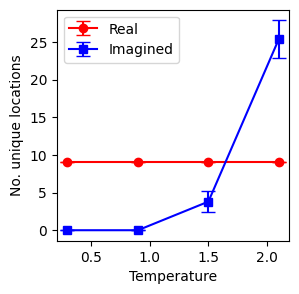

In [90]:
data_to_plot = [(1, 0.3), (1, 0.9), (1, 1.5), (1, 2.1)]

temperatures = []
total_real_locs = []
total_fake_locs = []
error_real_locs = []  # For SEM of real locations
error_fake_locs = []  # For SEM of fake locations

for d in data_to_plot:
    temperatures.append(d[1])  # Extract temperature
    real_locs = word_counts[d][0]  # List of counts for real locations
    fake_locs = word_counts[d]['No env']  # List of counts for fake locations
    
    total_real_locs.append(np.mean(real_locs))
    total_fake_locs.append(np.mean(fake_locs))
    
    error_real_locs.append(sem(real_locs))  # Calculate SEM for real locations
    error_fake_locs.append(sem(fake_locs))  # Calculate SEM for fake locations

# Plotting
plt.figure(figsize=(3, 3))
plt.errorbar(temperatures, total_real_locs, yerr=error_real_locs, label='Real', marker='o', color='red', linestyle='-', capsize=5)
plt.errorbar(temperatures, total_fake_locs, yerr=error_fake_locs, label='Imagined', marker='s', color='blue', linestyle='-', capsize=5)

plt.xlabel('Temperature')
plt.ylabel('No. unique locations')
plt.legend()
plt.savefig('loc_type_breakdown_by_temp.png', dpi=500, bbox_inches='tight')
plt.show()


In [68]:
input_file = 'word_freq_results_imagined_final.pkl'

# Loading the data from the pickle file
with open(input_file, 'rb') as file:
    results_dict = pickle.load(file)

In [76]:
num_env=5
temps = [-1.0, 0.3, 0.6, 0.9, 1.2, 1.5, 1.8]
word_counts = {(model, temp): {env: 0 for env in range(num_env)} for model in range(5) for temp in temps}

for record in results_dict:
    model, temp, locs, training_strs = record['model'], record['temp'], record['locs'], record['training_strs']
    if 'No env' not in word_counts[(model, temp)]:
        word_counts[(model, temp)]['No env'] = 0
    for word in locs:
        found = False
        for env in range(num_env):
            if word in get_unique_locations(training_strs[env]):
                word_counts[(model, temp)][env] += 1
                found = True
        if found is False:
            word_counts[(model, temp)]['No env'] += 1


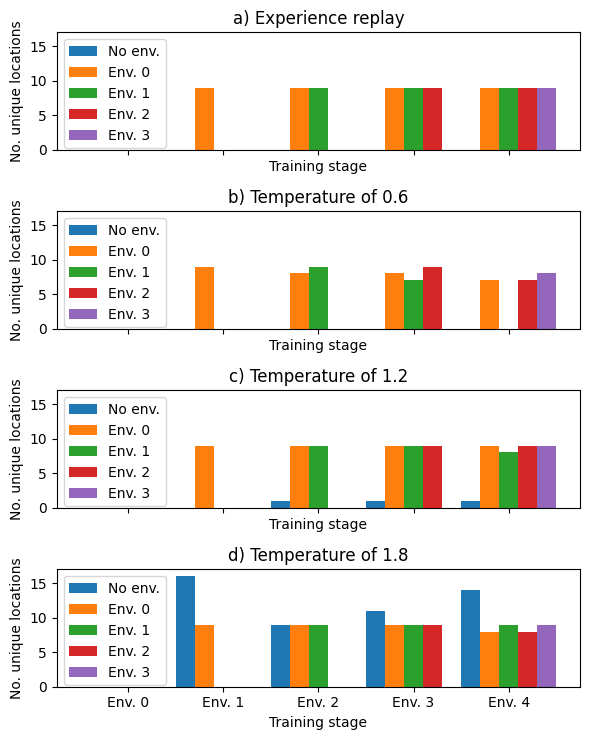

In [77]:
fig, axes = plt.subplots(4, 1, figsize=(6, 7.5), sharex=True)
bar_width = 0.20  

for i, temp in enumerate([-1, 0.6, 1.2, 1.8]):
    indices = np.arange(num_env)  
    offsets = np.linspace(-bar_width * 5 / 2, bar_width * 5 / 2, 6)
    
    for j, env in enumerate(['No env'] + [env for env in range(num_env) if env != 4]):
        env_data = [word_counts[(model, temp)].get(env, 0) for model in range(num_env)]
        axes[i].bar(indices + offsets[j], env_data, width=bar_width, label=f'Env. {env}' if env != 'No env' else 'No env.')
    
    axes[i].set_xticks([i-(bar_width/2) for i in indices])  
    axes[i].set_xticklabels([f'Env. {model}' for model in range(5)])
    axes[i].set_xlabel('Training stage')
    axes[i].set_ylabel('No. unique locations')
    axes[i].set_title(f'{string.ascii_lowercase[i]}) Temperature of {temp}' if i > 0 else 'a) Experience replay')
    axes[i].set_ylim(0,17)
    axes[i].legend()

plt.tight_layout()
plt.savefig('location_breakdown_by_temp.png', dpi=500)
plt.show()